

**Version 1.00**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import keras,os,cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import *

In [4]:
train_path = '/content/drive/MyDrive/Personal/Projects/DFU/Patches'
test_path = '/content/drive/MyDrive/Personal/Projects/DFU/TestSet'

batch_size = 32
img_height = 300
img_width = 300
num_classes = 2
epochs = 20

In [5]:
# Load the Training and Validation Dataset
train_ds = image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = batch_size,
    image_size = (img_width, img_height),
    subset = 'training',
    seed = 0
)

validation_ds = image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    validation_split = 0.2,
    batch_size = batch_size,
    image_size = (img_width, img_height),
    subset = 'validation',
    seed = 0
)

Found 1055 files belonging to 2 classes.
Using 844 files for training.
Found 1055 files belonging to 2 classes.
Using 211 files for validation.


In [6]:
# Load Test Dataset
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

test_ds = tf.data.Dataset.list_files(str(test_path + '/*'), shuffle=False)
# test_ds = test_ds.shuffle(len(os.listdir(TEST_PATH)), reshuffle_each_iteration=False)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
# Get the class names
class_names = train_ds.class_names
print(class_names)

['Abnormal(Ulcer)', 'Normal(Healthy skin)']


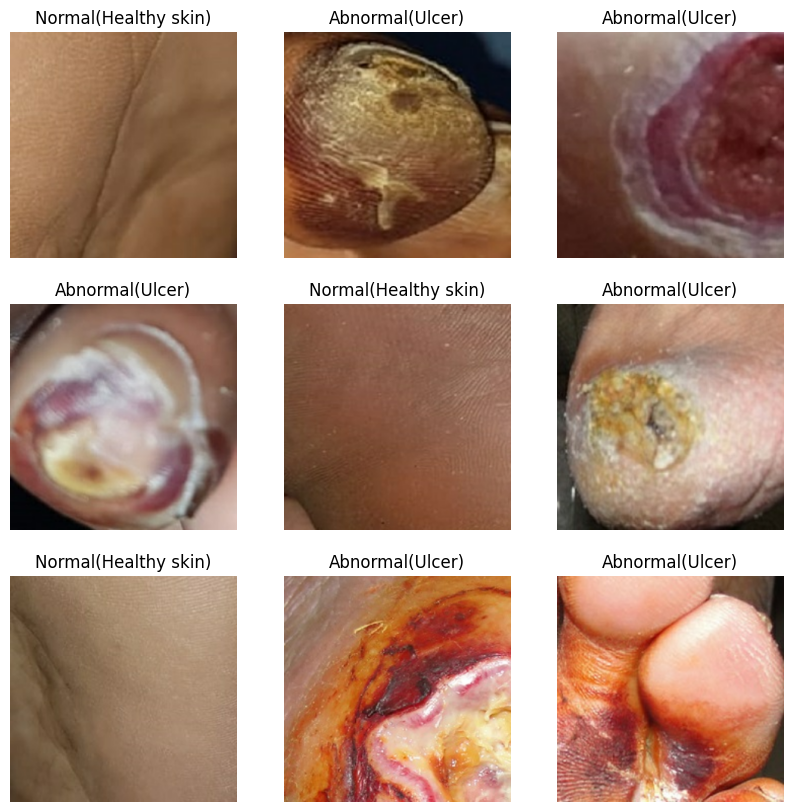

In [8]:
# Visualize the training dataset
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

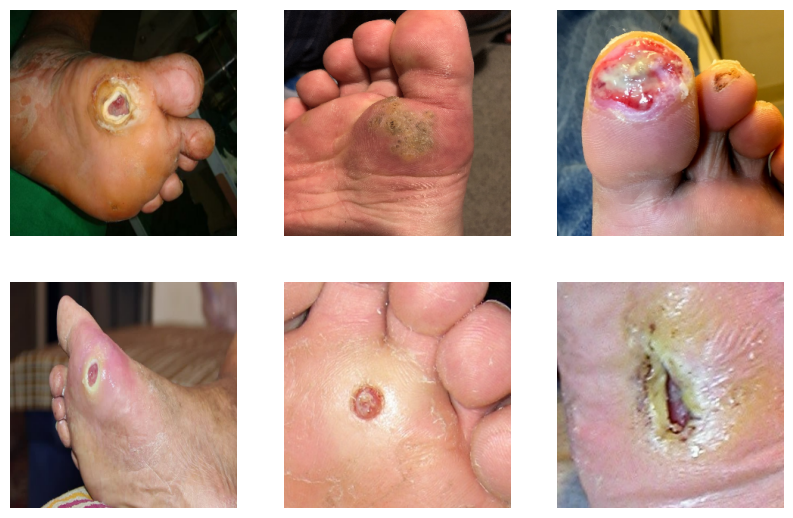

In [9]:
# Visualize the testing dataset
plt.figure(figsize = (10, 10))

i = 0
for images in test_ds.take(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.axis("off")
    i += 1

In [10]:
# Layers of Augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.15),
        layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation((-0.2, 0.3)),
        layers.GaussianNoise(stddev = 0.09),
        layers.RandomContrast(factor = 0.1),
    ],
    name = "img_augmentation"
)

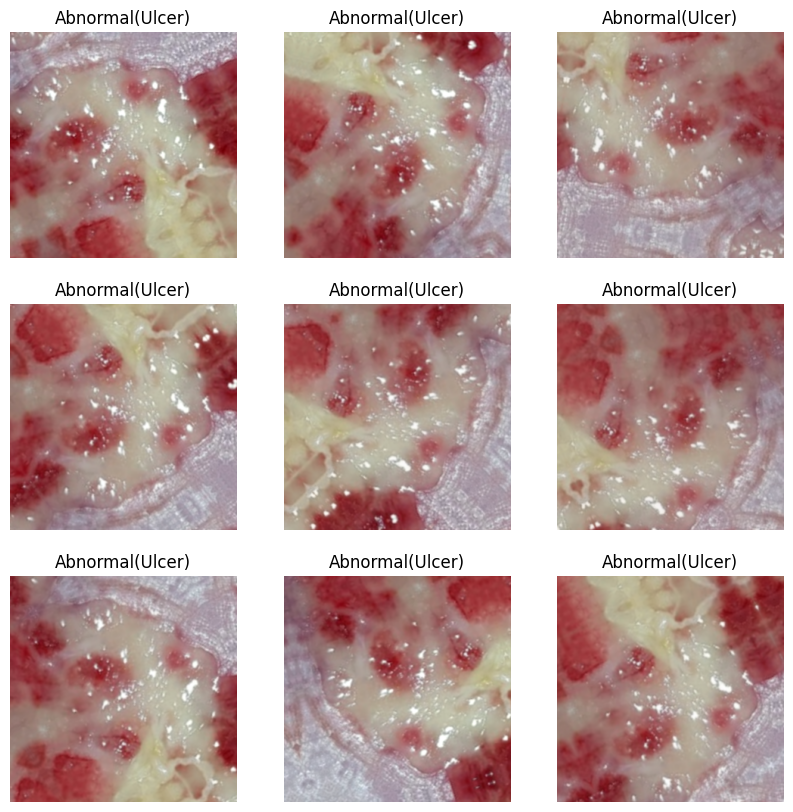

In [11]:
# View the augmentations
plt.figure(figsize = (10, 10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis = 0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [12]:
# Caching and Prefetching (Optimization)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
# Define Callbacks
lr_callback = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5)
stop_callback = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8)

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [15]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(resnet.input,output)

for layer in resnet.layers :
  layer.trainable = False
resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [17]:
model = Sequential()
model.add(resnet)
model.add(Dense(512,activation = 'relu' , input_dim = (img_height,img_width,3)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='relu'))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 204800)            23587712  
                                                                 
 dense (Dense)               (None, 512)               104858112 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 128,446,337
Trainable params: 104,858,625
Non-trainable params: 23,587,712
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
history = model.fit(train_ds, epochs=20, validation_data=validation_ds, verbose = 1)

Epoch 1/20
27/27 [==============================] - 114s 4s/step - loss: 3.0958 - accuracy: 0.7903 - val_loss: 0.4437 - val_accuracy: 0.9668
Epoch 2/20
27/27 [==============================] - 6s 238ms/step - loss: 0.5636 - accuracy: 0.9633 - val_loss: 0.3756 - val_accuracy: 0.9716
Epoch 3/20
27/27 [==============================] - 6s 241ms/step - loss: 0.4626 - accuracy: 0.9668 - val_loss: 0.1572 - val_accuracy: 0.9858
Epoch 4/20
27/27 [==============================] - 7s 242ms/step - loss: 0.4056 - accuracy: 0.9704 - val_loss: 0.4386 - val_accuracy: 0.9716
Epoch 5/20
27/27 [==============================] - 6s 240ms/step - loss: 0.3335 - accuracy: 0.9763 - val_loss: 0.5117 - val_accuracy: 0.9668
Epoch 6/20
27/27 [==============================] - 7s 250ms/step - loss: 0.2556 - accuracy: 0.9822 - val_loss: 0.6716 - val_accuracy: 0.9479
Epoch 7/20
27/27 [==============================] - 6s 242ms/step - loss: 0.2738 - accuracy: 0.9822 - val_loss: 0.4386 - val_accuracy: 0.9716
Epoch 8

In [19]:
model.save("DFUDeepLearningModel.h5")

In [20]:
model.predict(validation_ds)

7/7 [==============================] - 2s 172ms/step


array([[ 0.       ],
       [15.4614   ],
       [ 0.       ],
       [ 9.053378 ],
       [22.135233 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [20.899431 ],
       [ 0.       ],
       [ 0.       ],
       [13.337859 ],
       [ 3.8557162],
       [14.122335 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [28.191954 ],
       [22.741234 ],
       [ 0.       ],
       [ 5.4635916],
       [ 0.       ],
       [ 0.       ],
       [26.35891  ],
       [12.150247 ],
       [ 0.       ],
       [18.244814 ],
       [ 0.       ],
       [31.231146 ],
       [20.422335 ],
       [ 0.       ],
       [14.345835 ],
       [23.1409   ],
       [ 0.       ],
       [25.079887 ],
       [19.100496 ],
       [ 0.       ],
       [ 0.       ],
       [27.671387 ],
       [ 0.       ],
       [ 0.       ],
       [14.299802 ],
       [18.584066 ],
       [26.715591 ],
       [ 0.       ],
       [ 0.       ],
       [ 0.  

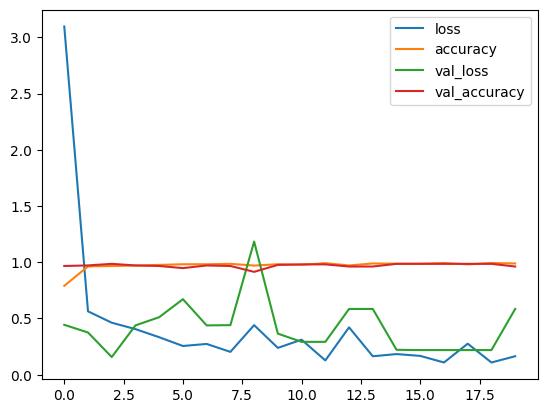

In [21]:
pd.DataFrame(history.history).plot()
plt.show()

In [44]:
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Personal/Projects/DFU/Original Images/2.jpg')
img = np.array(image)
img = img/255.0
print(img.shape)
print(len(train_ds))
img = tf.keras.preprocessing.image.smart_resize(img,(img_height,img_width))
label = model.predict(img)
print(label)

(579, 1447, 3)
27


ValueError: ignored

In [38]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB

In [39]:
import gradio as gr

In [47]:
def detection(img):
  img = img.reshape((-1,300,300,3))
  prediction = model.predict(img).flatten()
  output = class_names[prediction]
  return output

deploy = gr.Interface(fn=detection,inputs=gr.Image(shape=(300,300)),outputs=gr.Label(num_top_classes=2))
deploy.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 1s/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 401, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1302, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1025, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-47-91e871df05e0>", line 4, in detection
    output = class_names[prediction]
TypeError: only integer scalar 

Keyboard interruption in main thread... closing server.
